# Prediction error, cross-validation, and significance testing

In the previous notebook we showed a few different models. We should have a way to evaluate our models and possibly  to choose the best one. In the previous examples we calculated mean square error for training data, but this is not a value we should care most, at the end we build models to predict response from new input data. 

Let's explore the topic of model validation and understanding various errors for regression models. We will start from creating a new dataset:

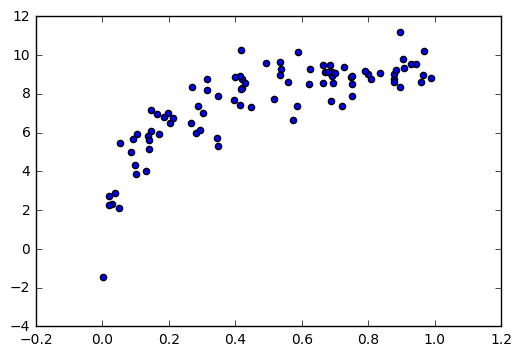

In [162]:
import numpy as np
def make_data(N=90, error=1.0, random_seed=1):
    def test_func(x, err=0.5):
        y = 10 - 1. / (x + 0.1)
        if err > 0:
            y = np.random.normal(y, err)
        return y

    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

X, y = make_data()
plt.scatter(X.ravel(), y)

Let's divide this time our data for two sets that we will call training and test, and build a simple linear regression model using training data only:

In [163]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

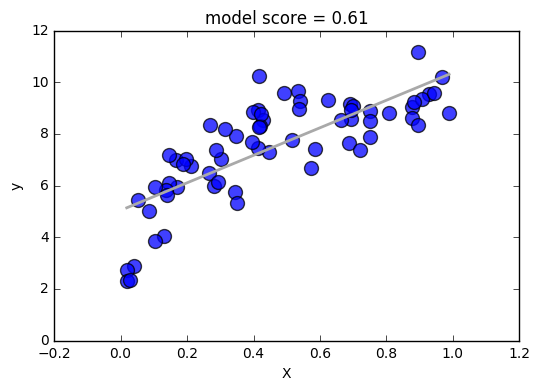

In [171]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(X_train, y_train)

def plot_regr(X, y, model, color="b"):
    fig, ax = plt.subplots()
    
    X_pr = np.linspace(X[:,0].min(), X[:,0].max(), 100)[:, np.newaxis]
    y_pr = model.predict(X_pr)
    ax.plot(X_pr, y_pr, color='darkgrey', linewidth=2)
    ax.scatter(X[:,0], y, s=100, alpha=0.75, c=color)

    ax.set_title("model score = {:03.2f}".format(model.score(X,y)))
    ax.set_xlabel('X')
    ax.set_ylabel('y')

plot_regr(X_train, y_train, regr)

As you can see, our model is not doing a great job and we might want to try more complex model, e.g. including polynomial terms.

In [172]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

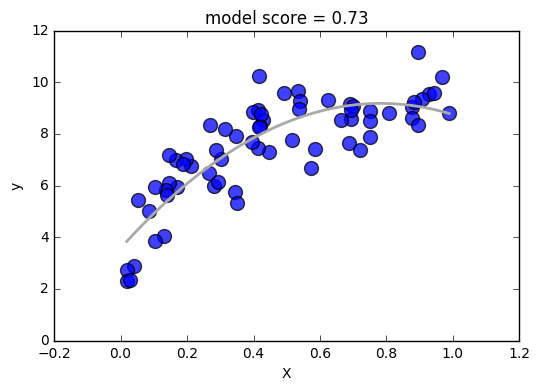

In [173]:
poly2 = PolynomialRegression(2)
poly2.fit(X_train, y_train)
plot_regr(X_train, y_train, poly2)

This is much better, so we might try to go to even higher polynomials.

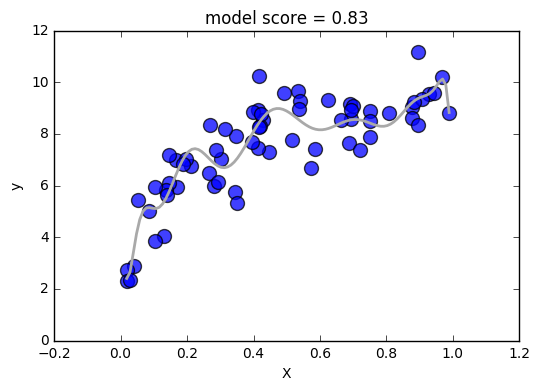

In [174]:
poly15 = PolynomialRegression(15)
poly15.fit(X_train, y_train)
plot_regr(X_train, y_train, poly15)

That seems to be even better fit to our data. But how does it work for part of dataset that was not used for training, i.e. the test set.

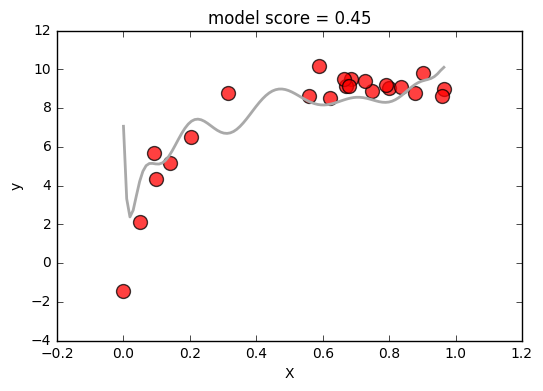

In [175]:
plot_regr(X_test, y_test, poly15, color="r")

Now we can see that for the test set the model doesn't look so great and the score is not impressive. It is actually lower than for the first linear model we built:

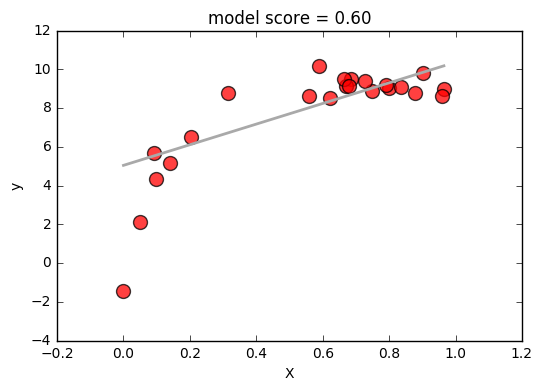

In [176]:
plot_regr(X_test, y_test, regr, color="r")

The best results we have for poly2:

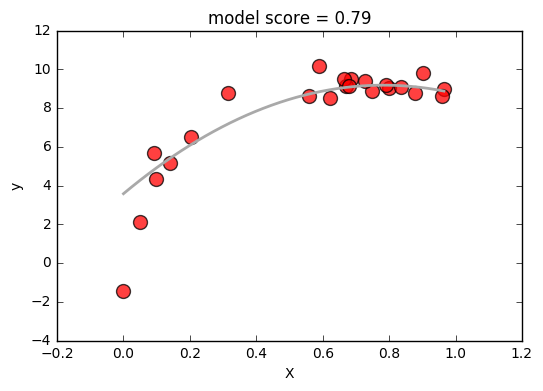

In [170]:
plot_regr(X_test, y_test, poly2, color="r")

The problem is related to the [**bias–variance tradeoff**](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). The **bias** is error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs and it's also called **underfitting**. The **variance** is error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs and it's also called **overfitting**.

In order to evaluate models **prediction error** is used. Expected prediction error can be written:

\begin{aligned}{\mathrm  {E}}{\Big [}{\big (}y-{\hat  {f}}(x){\big )}^{2}{\Big ]}&={\mathrm  {Bias}}{\big [}{\hat  {f}}(x){\big ]}^{2}+{\mathrm  {Var}}{\big [}{\hat  {f}}(x){\big ]}+\sigma ^{2}\\\end{aligned}
where bias:

\begin{aligned}\mathrm {Bias} {\big [}{\hat {f}}(x){\big ]}=\mathrm {E} {\big [}{\hat {f}}(x)-f(x){\big ]}\end{aligned}

and variance:

\begin{aligned}\mathrm {Var} {\big [}{\hat {f}}(x){\big ]}=\mathrm {E} [{\hat {f}}(x)^{2}]-\mathrm {E} [{\hat {f}}(x)]^{2}\end{aligned}

and $\sigma^2$ is irreducible error.

All terms are positive and in order to minimize the value we have to minimize bias and/or variance. When we are increasing complexity of the model we're decreasing bias, but increasing variance, so we should always try to find optimal solution, that is schematically presented in the figure:

<img src="../img/bias_var_modcomplex.png", width=500>


Another way of thinking about it can be thinking about training error vs predicted/test error. When we are building more complex model we are decreasing training error but the difference between test and training error at some point starts increasing faster. 

<img src="../img/error_complexity.png", width=500>

TODO - write about data size and bias/variance??

Now we know why we divided our dataset to training and testing sets, but this has also some drawbacks, the biggest one is that we are not using a part of our data to build  a better model. If you have large dataset it's not a problem, but often in neuroscientific studies this is not the case.

<img src="../img/train_test.png", width=200>

To address this issue, sometimes a **croass validation** approach is used. TODO- explain more

<img src="../img/cv.png", width=200>

In [177]:
from sklearn.cross_validation import cross_val_score
print(cross_val_score(regr, X, y, cv=None))#, scoring='precision')
print(cross_val_score(poly2, X, y, cv=None))
print(cross_val_score(poly15, X, y, cv=None))

[ 0.55280768  0.62096582  0.62899577]
[ 0.74106042  0.7598275   0.69354111]
[ 0.63291862 -3.4629217   0.69988795]


TODO: should I include model selection - dividing dataset to three parts - training CV, testing?

## Error metrics for classification

In order to validate binary classification models we are using **error matrix** (or confusion matrix): 
    
<img src="../img/sensit_specif.png", width=500>

The error matric describes four possible scenarios. Since the true response is either Positive or Negative (or 1/0) and model prediction can also have these two value for every sample. That gives us for possibilities:
 - **True Positive (TP)**: model correctly identifies Positive cases, e.g. correctly classifies people with malignant cancer
is a table that 
 - ** False Positive (FP)**:  model incorrectly identifies Positive cases, e.g. predict malignant cancer for people with benign cancer
 - **True Negative (TN)**: model correctly identifies Negative cases, e.g. correctly classifies people with benign cancer
 - **False Negative (FN)**: model incorrectly identifies Negative cases, e.g. predict benign cancer for people with malignant cancer
 
Of course, we would like to have only True Positives and True Negatives, but we often want to have one value to optimize, from error matrix we can calculate following rates:

 - **Precision**: $\frac{TP}{TP + FP}$
 - **Recall**: $\frac{TP}{TP + FN}$
 - **Sensitivity**: $\frac{TP}{TP + FN}$
 - **Specificity**: $\frac{TN}{TN + FP}$ 
 
Ther is always trade-off between Precision and Recall or Sensitivity and Specificity. Sometimes additional scores are defined:

**F score**: $\frac{Precision * Recall}{Precision + Recall}$

Let's calculate values of Precision and Recall for the breast cancer dataset (but splitting data to training and testing sets this time):

In [106]:
cancer = datasets.load_breast_cancer()

X_can = cancer.data
y_can = cancer.target

X_can_tr, X_can_ts, y_can_tr, y_can_ts = train_test_split(X_can, y_can)

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf.fit(X_can_tr[:, :2], y_can_tr)
y_pred = clf.predict(X_can_ts[:, :2])

In [107]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_can_ts, y_pred), recall_score(y_can_ts, y_pred)

(0.81904761904761902, 0.9662921348314607)

We diagnosed correctly almost 97% of people with malignant cancer, so it sounds as a pretty nice results. But at the same time 18% of people who were diagnosed with malignant cancer didn't actually have one and they might have mixed feelings...

And what if we take all features into account?

In [108]:
clf_full = KNeighborsClassifier()
clf_full.fit(X_can_tr, y_can_tr)
y_pred = clf_full.predict(X_can_ts)
precision_score(y_can_ts, y_pred), recall_score(y_can_ts, y_pred)

(0.90625, 0.97752808988764039)

This looks better! We didn't improve recall too much, but we do have much less FP, so our precision is higher.

## significance testing

TODO: 
can I actually do it with cancer data? and test hyphothesis if cancer bigger than something are malignant??